## ME 397 Applied Engineering Data Analysis, Optimization, and Visualization

#### Srushikesh Siriya Durai (ss94586)

### Predictive Maintenance Analytics

<b>About the data</b> <br>
The AI4I 2020 Predictive Maintenance Dataset is a synthetic dataset that reflects real predictive maintenance data encountered in industry.

The dataset consists of 10,000 data points stored as rows with 14 features in columns:- <br>
UID: unique identifier ranging from 1 to 10000. <br>
product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number. <br>
air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K. <br>
process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K. <br>
rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise. <br>
torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values. <br>
tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. <br> 
machine failure label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

<b>Objective</b> <br>
Perform EDA and identify factors affecting equipment failure. Apply machine learning models to predict tool wear, heat dissipation, overstrain, and power failures. Predicting machine failure will prevent from expensive outages alleviate the damage caused  by breakdowns.

#### Importing Libraries

In [1]:
### Importing Basics packages and Visualization packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### To display all the columns
pd.set_option('display.max_columns', 500)

### Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

### Classifications Model
from sklearn.tree import DecisionTreeClassifier

### Metrics
from sklearn.metrics import confusion_matrix

### Spliting Train Test Data and Hypertuning Techniques
from sklearn.model_selection import train_test_split

#### Reading Data

In [2]:
data = pd.read_csv('ai4i2020.csv')
data.head(3)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


In [3]:
### Renaming Columns 
data.columns= ['UDI','Product','Type','Air_Temp','Process_Temp','Rotational_Speed',\
               'Torque','Tool_Wear','Machine_Failure','TWF','HDF','PWF','OSF','RNF']

#### Exploring the Data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UDI               10000 non-null  int64  
 1   Product           10000 non-null  object 
 2   Type              10000 non-null  object 
 3   Air_Temp          10000 non-null  float64
 4   Process_Temp      10000 non-null  float64
 5   Rotational_Speed  10000 non-null  int64  
 6   Torque            10000 non-null  float64
 7   Tool_Wear         10000 non-null  int64  
 8   Machine_Failure   10000 non-null  int64  
 9   TWF               10000 non-null  int64  
 10  HDF               10000 non-null  int64  
 11  PWF               10000 non-null  int64  
 12  OSF               10000 non-null  int64  
 13  RNF               10000 non-null  int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 1.1+ MB


In [5]:
data.isnull().sum()

UDI                 0
Product             0
Type                0
Air_Temp            0
Process_Temp        0
Rotational_Speed    0
Torque              0
Tool_Wear           0
Machine_Failure     0
TWF                 0
HDF                 0
PWF                 0
OSF                 0
RNF                 0
dtype: int64

<AxesSubplot:xlabel='Type', ylabel='count'>

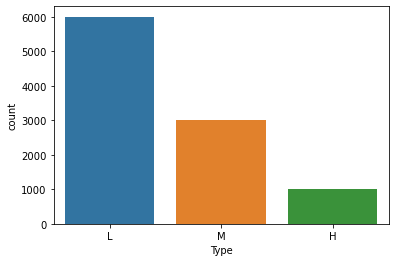

In [6]:
sns.countplot(data['Type'], order=data['Type'].value_counts(ascending = False).index)

From the Data description H, M, and L are product quality where H - High, M - Medium, and L - Low. We will replace H, M, and L to 1, 2, and 3 respectively. So that we have all our columns in numbers. 

In [7]:
data['Type'].replace({'H':1,'M':2,'L':3},inplace=True)

#### Understanding the Types of Failure #####
1. Tool Wear Failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 and 240 mins. <br>
2. Heat Dissipation Failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tool rotational speed is below 1380 rpm. <br>
3. Power Failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails. <br>
4. Overstrain Failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain.<br>
5. Random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. <br>

In [8]:
data[['Machine_Failure','TWF','HDF','PWF','OSF','RNF']].sum()

Machine_Failure    339
TWF                 46
HDF                115
PWF                 95
OSF                 98
RNF                 19
dtype: int64

In [9]:
features = ['Air_Temp','Process_Temp','Rotational_Speed','Torque','Tool_Wear','Type']

<AxesSubplot:>

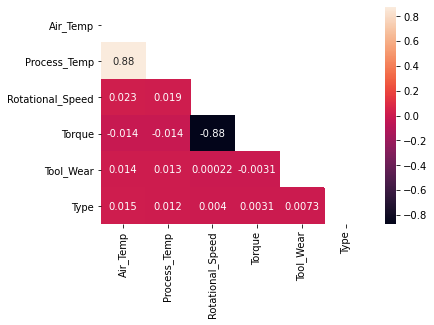

In [10]:
### Understanding the Correlation between features
mask = np.triu(np.ones_like(data[features].corr(), dtype=bool))
sns.heatmap(data[features].corr(),annot=True,mask = mask)

Mean Air Temp:  300.00492999999875
Mean Process Temp:  310.00555999999995


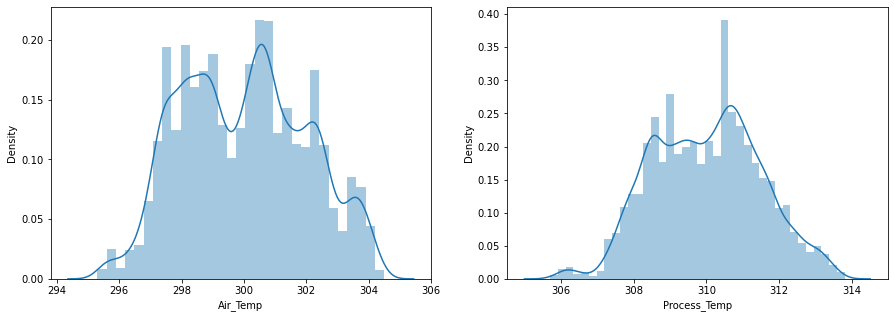

In [11]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
sns.distplot(data['Air_Temp'] ,ax = ax[0])
sns.distplot(data['Process_Temp'] ,ax = ax[1])

print("Mean Air Temp: ",data['Air_Temp'].mean())
print("Mean Process Temp: ",data['Process_Temp'].mean())

<AxesSubplot:xlabel='Rotational_Speed', ylabel='Torque'>

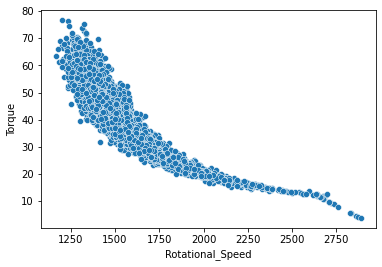

In [12]:
sns.scatterplot(y = data['Torque'], x = data['Rotational_Speed'])

1. Positive correlation between Process and Air temperature makes sense the as the Process Temp will be slightly higher than the ambient temperature due to process running. <br>
2. Torque and Rotational Speed are negatively correlated which is aligned with the physics concepts. Multiplying these metrics will yield Power <br>
3. Other metrics seems to be uncorrelated

<AxesSubplot:xlabel='Difference_Temp', ylabel='Density'>

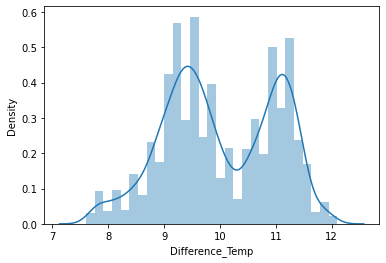

In [13]:
data['Difference_Temp'] = data['Process_Temp'] - data['Air_Temp']
features.append('Difference_Temp')
sns.distplot(data['Difference_Temp'])

<AxesSubplot:xlabel='Rotational_Speed', ylabel='Torque'>

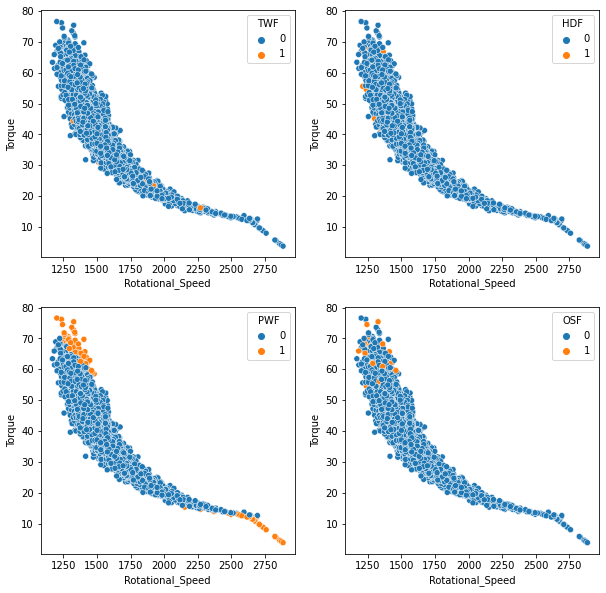

In [14]:
fig, ax = plt.subplots(2,2,figsize = (10,10))
sns.scatterplot(x = data['Rotational_Speed'], y = data['Torque'], hue = data['TWF'], ax = ax[0,0])
sns.scatterplot(x = data['Rotational_Speed'], y = data['Torque'], hue = data['HDF'], ax = ax[0,1])
sns.scatterplot(x = data['Rotational_Speed'], y = data['Torque'], hue = data['PWF'], ax = ax[1,0])
sns.scatterplot(x = data['Rotational_Speed'], y = data['Torque'], hue = data['OSF'], ax = ax[1,1])

The graphs clearly shows that PWF happens either when torque or rotational speed is high. 

<AxesSubplot:xlabel='Power', ylabel='PWF'>

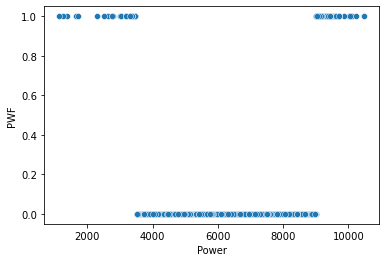

In [15]:
data['Power'] = data['Rotational_Speed'] * data['Torque']/9.5488
features.append('Power')
sns.scatterplot(x = data['Power'], y = data['PWF'])

<AxesSubplot:xlabel='Tool_Wear', ylabel='Torque'>

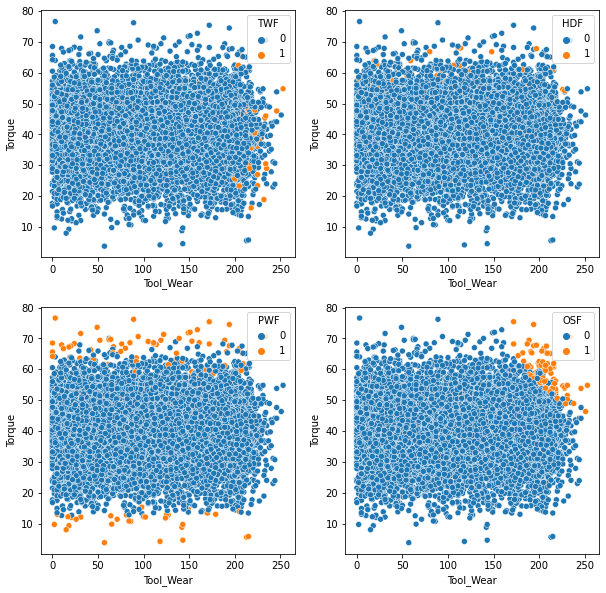

In [16]:
fig, ax = plt.subplots(2,2,figsize = (10,10))
sns.scatterplot(x = data['Tool_Wear'], y = data['Torque'], hue = data['TWF'], ax = ax[0,0])
sns.scatterplot(x = data['Tool_Wear'], y = data['Torque'], hue = data['HDF'], ax = ax[0,1])
sns.scatterplot(x = data['Tool_Wear'], y = data['Torque'], hue = data['PWF'], ax = ax[1,0])
sns.scatterplot(x = data['Tool_Wear'], y = data['Torque'], hue = data['OSF'], ax = ax[1,1])

The above graphs shows that Overstrain Failure happens when Torque and Tool Wear time is high

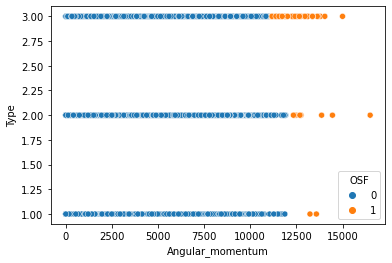

In [17]:
data['Angular_momentum'] = data['Tool_Wear'] * data['Torque']
sns.scatterplot(x = data['Angular_momentum'], y = data['Type'], hue = data['OSF'])
features.append('Angular_momentum')

<AxesSubplot:xlabel='Rotational_Speed', ylabel='Difference_Temp'>

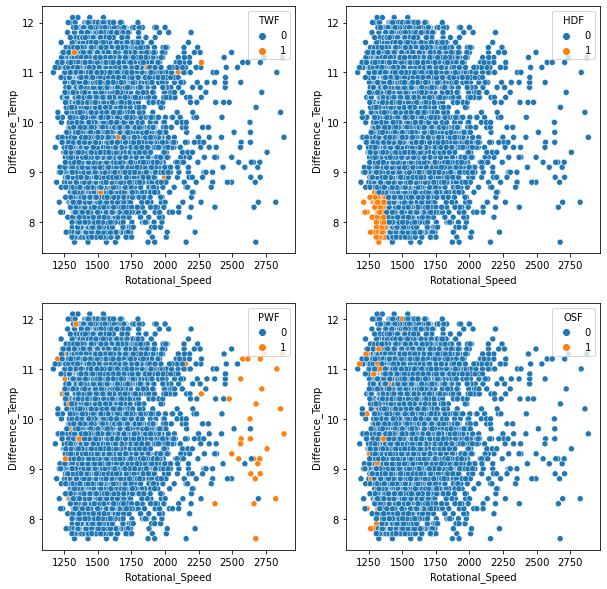

In [18]:
fig, ax = plt.subplots(2,2,figsize = (10,10))
sns.scatterplot(x = data['Rotational_Speed'], y = data['Difference_Temp'], hue = data['TWF'], ax = ax[0,0])
sns.scatterplot(x = data['Rotational_Speed'], y = data['Difference_Temp'], hue = data['HDF'], ax = ax[0,1])
sns.scatterplot(x = data['Rotational_Speed'], y = data['Difference_Temp'], hue = data['PWF'], ax = ax[1,0])
sns.scatterplot(x = data['Rotational_Speed'], y = data['Difference_Temp'], hue = data['OSF'], ax = ax[1,1])

HDF happens when the temperature difference and the rotational speed is minimum

<AxesSubplot:xlabel='Tool_Wear', ylabel='TWF'>

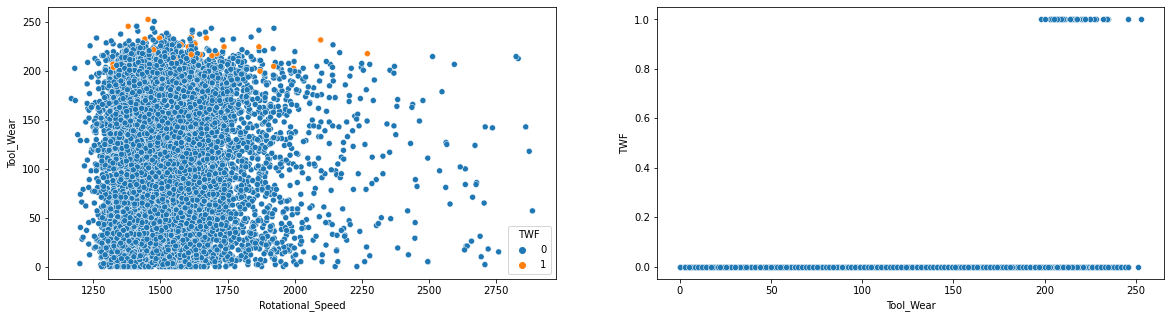

In [19]:
fig, ax = plt.subplots(1,2,figsize = (20,5))
sns.scatterplot(x = data['Rotational_Speed'], y = data['Tool_Wear'], hue = data['TWF'], ax = ax[0])
sns.scatterplot(x = data['Tool_Wear'], y = data['TWF'], ax = ax[1])

There is a higher probability that Tool Wear can happen when it is used for prolonged period.

<AxesSubplot:xlabel='UDI', ylabel='Tool_Wear'>

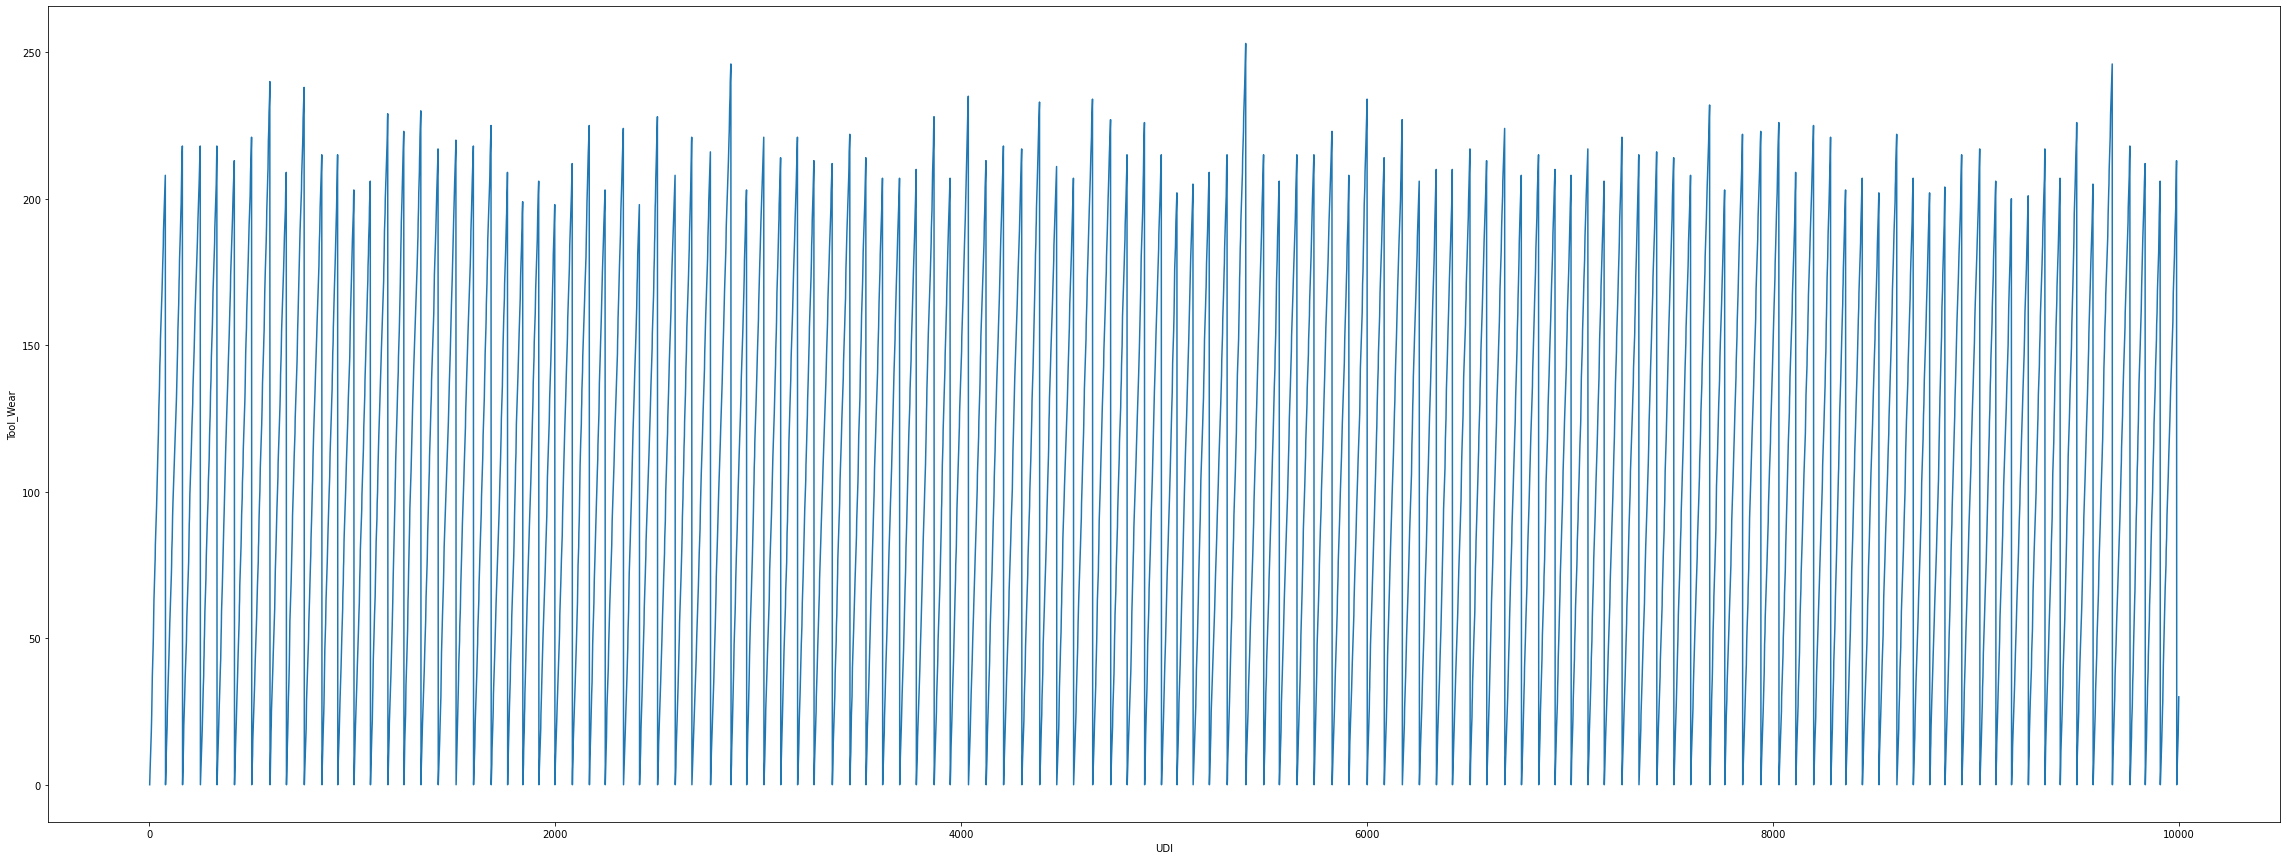

In [20]:
plt.figure(figsize=(40,15))
sns.lineplot(x = data['UDI'], y = data['Tool_Wear'])

A tool starts from 0 and runs upto 250 and then the tool is changed. P.S. The max run time of tool is although different. It is possible that the tool is changed due to Tool Wear Failure. 

We can identify positions where the tool is changed then we can analyze the TWF point. 

In [21]:
next_tool_wear_time = data[['UDI','Tool_Wear']].copy()
next_tool_wear_time['UDI'] = next_tool_wear_time['UDI']+1

next_tool_wear_time = next_tool_wear_time.append({'UDI':next_tool_wear_time['UDI'].min()-1,\
                                                  'Tool_Wear':-1},ignore_index=True)
next_tool_wear_time.drop(next_tool_wear_time[next_tool_wear_time['UDI']==next_tool_wear_time['UDI'].max()].index,inplace=True)
next_tool_wear_time.columns = ['UDI','Next_Tool_Wear']
next_tool_wear_time.sort_values('UDI',inplace=True)

In [22]:
data = pd.merge(data, next_tool_wear_time, left_on=['UDI'], right_on=['UDI'], how = 'left')

In [23]:
data.head(3)

,UDI,Product,Type,Air_Temp,Process_Temp,Rotational_Speed,Torque,Tool_Wear,Machine_Failure,TWF,HDF,PWF,OSF,RNF,Difference_Temp,Power,Angular_momentum,Next_Tool_Wear
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,10.5,6951.952078,0.0,-1
1,2,L47181,3,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,10.5,6827.077748,138.9,0
2,3,L47182,3,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,10.4,7749.790550,247.0,3


In [24]:
data['Tool_Change'] = np.where(data['Tool_Wear']>=data['Next_Tool_Wear'],0,1)

In [25]:
data['Tool_Change'].value_counts()

0    9881
1     119
Name: Tool_Change, dtype: int64

The tool was changed 119 times. The tool wear failure occurred 46 times.

In [26]:
data['Tool_Number'] = data['Tool_Change'].cumsum()
data['Tool_Number'] = data['Tool_Number']+1
data['Tool_Number'] = data['Tool_Number'].astype(str)
data['Tool_Number'] = data['Tool_Number'].str.zfill(3)
data['Tool_Number'] = 'T_'+data['Tool_Number']
data.drop(data[data['Tool_Number'] == 'T_120'].index,inplace=True)

In [27]:
tool_status = data[['Tool_Number','TWF','Tool_Wear']].groupby('Tool_Number')['Tool_Wear','TWF'].max().reset_index()

In [28]:
tool_status_1 = data['Tool_Number'].value_counts().reset_index()
tool_status_1.columns = ['Tool_Number','No_Process']
tool_status = pd.merge(tool_status, tool_status_1, on = 'Tool_Number', how = 'left')

<AxesSubplot:xlabel='No_Process', ylabel='Density'>

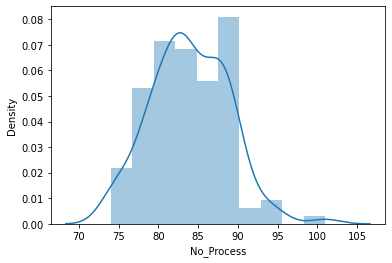

In [29]:
sns.distplot(tool_status['No_Process'])

A tool is used for on average 83 number of process.

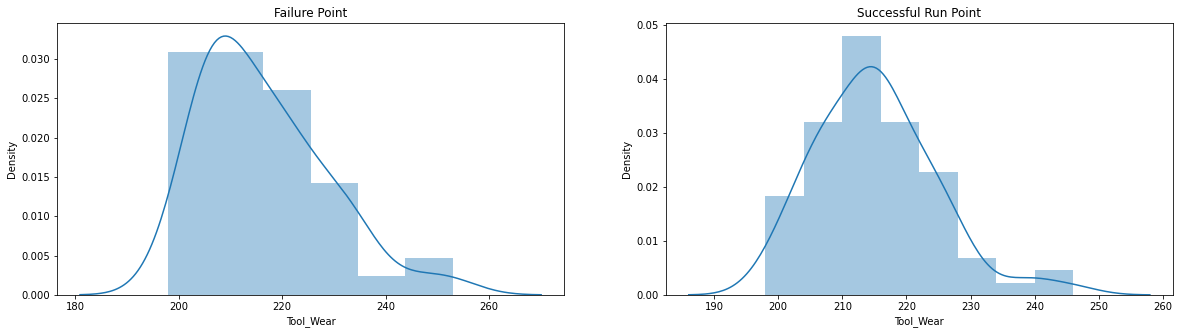

In [30]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(tool_status[tool_status['TWF']==1]['Tool_Wear'], ax = ax [0])
sns.distplot(tool_status[tool_status['TWF']==0]['Tool_Wear'], ax = ax [1])
ax[0].title.set_text('Failure Point')
ax[1].title.set_text('Successful Run Point')

In [31]:
data[data['Tool_Wear']>=200].groupby('Tool_Number')['TWF'].max().reset_index()['TWF'].value_counts()

0    71
1    45
Name: TWF, dtype: int64

The tool failure occurs 63% when it used for more than 200 mins. 

In [32]:
data.drop(['Next_Tool_Wear', 'Tool_Change', 'Tool_Number'],inplace=True, axis=1)

#### Modeling Approach

We will try to individually model each failure types using different models and combine the results to see if the machine will fail or not

In [33]:
twf = data[['UDI','TWF']]
hdf = data[['UDI','HDF']]
pwf = data[['UDI','PWF']]
osf = data[['UDI','OSF']]
rnf = data[['UDI','RNF']]
machine_fail = data[['UDI','Machine_Failure']]

drop_columns = ['Machine_Failure','TWF','HDF','PWF','OSF','RNF']

data.drop(drop_columns,axis=1,inplace=True)

In [34]:
### For Quality Check
print("TWF: \n",twf['TWF'].value_counts())
print("HDF: \n",hdf['HDF'].value_counts())
print("PWF: \n",pwf['PWF'].value_counts())
print("OSF: \n",osf['OSF'].value_counts())
print("RNF: \n",rnf['RNF'].value_counts())
print("Machine Failure: \n",machine_fail['Machine_Failure'].value_counts())

TWF: 
 0    9943
1      46
Name: TWF, dtype: int64
HDF: 
 0    9874
1     115
Name: HDF, dtype: int64
PWF: 
 0    9894
1      95
Name: PWF, dtype: int64
OSF: 
 0    9891
1      98
Name: OSF, dtype: int64
RNF: 
 0    9970
1      19
Name: RNF, dtype: int64
Machine Failure: 
 0    9650
1     339
Name: Machine_Failure, dtype: int64


In [35]:
data.columns

Index(['UDI', 'Product', 'Type', 'Air_Temp', 'Process_Temp',
       'Rotational_Speed', 'Torque', 'Tool_Wear', 'Difference_Temp', 'Power',
       'Angular_momentum'],
      dtype='object')

In [36]:
X_train, X_val, Y_train_twf, Y_val_twf = train_test_split(data, twf, test_size=0.25, random_state=42)

X_train.sort_values('UDI',inplace=True)
X_val.sort_values('UDI',inplace=True)

Y_train_twf.sort_values('UDI',inplace=True)
Y_val_twf.sort_values('UDI',inplace=True)

In [37]:
Y_train_hdf = hdf[hdf['UDI'].isin(Y_train_twf['UDI'])]
Y_val_hdf = hdf[hdf['UDI'].isin(Y_val_twf['UDI'])]

Y_train_pwf = pwf[pwf['UDI'].isin(Y_train_twf['UDI'])]
Y_val_pwf = pwf[pwf['UDI'].isin(Y_val_twf['UDI'])]

Y_train_osf = osf[osf['UDI'].isin(Y_train_twf['UDI'])]
Y_val_osf = osf[osf['UDI'].isin(Y_val_twf['UDI'])]

Y_train_rnf = rnf[rnf['UDI'].isin(Y_train_twf['UDI'])]
Y_val_rnf = rnf[rnf['UDI'].isin(Y_val_twf['UDI'])]

Y_train_mf = machine_fail[machine_fail['UDI'].isin(Y_train_twf['UDI'])]
Y_val_mf = machine_fail[machine_fail['UDI'].isin(Y_val_twf['UDI'])]

In [38]:
X_train.drop(['UDI','Product'],inplace=True,axis=1)
X_val.drop(['UDI','Product'],inplace=True,axis=1)

Y_train_twf.drop(['UDI'],inplace=True,axis=1)
Y_val_twf.drop(['UDI'],inplace=True,axis=1)

Y_train_hdf.drop(['UDI'],inplace=True,axis=1)
Y_val_hdf.drop(['UDI'],inplace=True,axis=1)

Y_train_pwf.drop(['UDI'],inplace=True,axis=1)
Y_val_pwf.drop(['UDI'],inplace=True,axis=1)

Y_train_osf.drop(['UDI'],inplace=True,axis=1)
Y_val_osf.drop(['UDI'],inplace=True,axis=1)

Y_train_rnf.drop(['UDI'],inplace=True,axis=1)
Y_val_rnf.drop(['UDI'],inplace=True,axis=1)

Y_train_mf.drop(['UDI'],inplace=True,axis=1)
Y_val_mf.drop(['UDI'],inplace=True,axis=1)

In [39]:
def model_performance(y_test,y_pred) : 
    #Conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))
    
    print("Model Summary \n")
    print(conf_matrix)
    print("\nAccuracy: ",Accuracy)
    print("Recall:  ",Recall)

In [40]:
### Predicting Heat Dissipation Failures - Decision Tree
DTC_hdf = DecisionTreeClassifier()
DTC_hdf.fit(X_train,Y_train_hdf)
DTC_hdf_pred = DTC_hdf.predict(X_val)
model_performance(Y_val_hdf, DTC_hdf_pred)

Model Summary 

[[2468    1]
 [   1   28]]

Accuracy:  0.9991993594875901
Recall:   0.9655172413793104


In [41]:
### Predicting Power Failures - Decision Tree
DTC_pwf = DecisionTreeClassifier()
DTC_pwf.fit(X_train,Y_train_pwf)
DTC_pwf_pred = DTC_pwf.predict(X_val)
model_performance(Y_val_pwf, DTC_pwf_pred)

Model Summary 

[[2469    0]
 [   0   29]]

Accuracy:  1.0
Recall:   1.0


In [42]:
### Predicting OverStrain Failures - Decision Tree
DTC_osf = DecisionTreeClassifier()
DTC_osf.fit(X_train,Y_train_osf)
DTC_osf_pred = DTC_osf.predict(X_val)
model_performance(Y_val_osf, DTC_osf_pred)

Model Summary 

[[2476    2]
 [   0   20]]

Accuracy:  0.9991993594875901
Recall:   1.0


In [43]:
### Predicting Tool Wear Failures - Decision Tree
DTC_twf = DecisionTreeClassifier()
DTC_twf.fit(X_train,Y_train_twf)
DTC_twf_pred = DTC_twf.predict(X_val)
model_performance(Y_val_twf, DTC_twf_pred)

Model Summary 

[[2474   17]
 [   7    0]]

Accuracy:  0.9903923138510808
Recall:   0.0


In [44]:
Strategy_twf_pred = np.where(X_val['Tool_Wear']>200,1,0)
model_performance(Y_val_twf, Strategy_twf_pred)

Model Summary 

[[2318  173]
 [   0    7]]

Accuracy:  0.9307445956765412
Recall:   1.0


In [45]:
machine_failure_pred = np.where((Strategy_twf_pred+DTC_osf_pred+DTC_pwf_pred+DTC_hdf_pred)>0,1,0)
model_performance(Y_val_mf, machine_failure_pred)

Model Summary 

[[2257  159]
 [   1   81]]

Accuracy:  0.9359487590072058
Recall:   0.9878048780487805


### Conclusion

A simple Decision Tree model is able to predict most of the failures. However, the model isn't able to capture the tool wear failure due to sporadic nature of the failure and imbalanced target value. From the graph in cell 20, we observed that the tool failure can happen anytime after 200 minutes of usage. <br>
1) We can tackle the issue by proactively changing the tool after using it for 200 minutes to avoid potential failure. <br>
2) Remodeling the Decision Tree after unsampling the target value by SMOTE technique.
